In [20]:
#Dependancies
import numpy as np
import math
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline
from scipy.optimize import fsolve, least_squares, minimize
from scipy.stats import qmc 
from scipy.linalg import norm
import random
import matplotlib.animation
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.signal import argrelmin, argrelmax
import matplotlib.pyplot as plt
from numba import jit
from tabulate import tabulate

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [12]:
# Convergence scheme

def magnitude (value):
    """Returns the magnitude (10 ** m) of a given value"""
    if (value == 0): return 0
    return int(math.floor(math.log10(abs(value))))

def ss_or_osc(sol):
        
    """
    state_sol should be a list representing a solution for a particular 
    state variable associated with a particular solution set
    
    Convergence Criteria:

    - For state solution state_sol, set reference value to the last time iterate of state_solution.
    - Work backwards, comparing each time iterate to the reference value: want to find 
      the first instance of when the state_solution has strayed too far from the reference,
      as determined by a specified threshold.

    - That first instance represents the time of convergence.
    - Example: l = 5 (solution with 5 time steps)
               ref = sol[-1] = sol[4]
               convergence at i = 3 yields sol[-4] = sol[2] = sol(5 - 3)
    
    """
    chunk = int(len(sol.t) * .75) #Last 25% of time span
    ss = []
    conv_time = []
    
    for k in range(7):
        
        index = 0
        state_sol = sol.y[k]
                
        l = len(state_sol) #Amount of time steps in a solution

        ref = state_sol[-1] #Reference value for which we compare the previous values to
#         print(k)
#         print(f"ref:{ref}")
        
        ss.append(ref)
        
        mag = magnitude(ref * .01) # Define threshold at 1% of ref
#         print(f"mag:{mag}")
        
        rel_tol = max(10 ** mag, 1e-10) # addresses exponential decay terms
#         print(f"rel_tol:{rel_tol}")
#         print()
        
        #Check if oscillations occur
        y_end = state_sol[chunk: ] #look at tail end of specific state

        l_min = argrelmin(y_end)[0]  #Extracting local minimum 
        l_max = argrelmax(y_end)[0]  #and maximum

        if (len(l_min) != 0) and (len(l_max) != 0): 
            return 'osc' # Return identifier, exit loop

        # If no oscillations present
        # Work backwards to find time of convergence
        for i in range(2, l): # Work backwards comparing each time step to the ref

            if not math.isclose(state_sol[-i], ref, rel_tol=rel_tol): 
                index = l - i + 1 #(plus 1 for previous time step, ie. last step that passed the threshold)
                break
        
        conv_time.append(index)
        
    return ss, conv_time
            

In [1]:
%store -r ss_sols
%store -r osc_sols

In [4]:
len(ss_sols) # [Initial condition, numerical solution, steady state solution values, time index of convergence]

4758

In [14]:
ss_sols[1]

([0, 2e-05, 2e-05, 1e-07, 2e-05, 1e-07, 2.0176073164229287e-10],
   message: The solver successfully reached the end of the integration interval.
   success: True
    status: 0
         t: [ 0.000e+00  1.000e-01 ...  6.999e+02  7.000e+02]
         y: [[ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
             [ 2.000e-05  2.021e-05 ...  6.020e-05  6.020e-05]
             ...
             [ 1.000e-07  9.984e-08 ...  8.252e-13  8.252e-13]
             [ 2.018e-10  3.486e-10 ...  7.302e-23  7.266e-23]]
       sol: None
  t_events: None
  y_events: None
      nfev: 9493
      njev: 353
       nlu: 353,
 [0.0,
  6.0200198637293496e-05,
  1.27781734111973e-20,
  6.839466734275746e-138,
  1.3618013987673533e-20,
  8.252222097880992e-13,
  7.265616733558303e-23],
 [0, 3142, 7000, 7000, 7000, 5550, 7000])

In [5]:
len(osc_sols) # [Initial condition, numerical solution]

362

**Individual state variable data**

In [15]:
# creates a data set where each solution's initial conditions are 
# paired with their respective steady state / long-time tendancy solution

labels = "N_n", "N_r", "P_U", "P_I", "Z", "V_I", "V_E"

data = []

for i, (z0, sol, ss, conv_time) in enumerate(ss_sols):
    
     for k, state in enumerate(labels):

        data.append((i, state, z0[k], ss[k], sum(z0), sol.t[conv_time[k]]))

In [16]:
df = pd.DataFrame(data, columns = ['Solution #', 'State Variable', 'Initial Condition', 'Steady State', 'Total N', "Convergence Time"])

In [17]:
df[:15] 

,Solution #,State Variable,Initial Condition,Steady State,Total N,Convergence Time
0,0,N_n,0.000000e+00,0.000000e+00,0.00006,0.0
1,0,N_r,2.000000e-05,6.020012e-05,0.00006,314.2
2,0,P_U,2.000000e-05,1.278071e-20,0.00006,700.0
3,0,P_I,1.000000e-07,7.109200e-138,0.00006,700.0
4,0,Z,2.000000e-05,1.361801e-20,0.00006,700.0
5,0,V_I,1.000000e-07,8.203956e-13,0.00006,555.1
6,0,V_E,1.209524e-10,7.299043e-23,0.00006,700.0
7,1,N_n,0.000000e+00,0.000000e+00,0.00006,0.0
8,1,N_r,2.000000e-05,6.020020e-05,0.00006,314.2
9,1,P_U,2.000000e-05,1.277817e-20,0.00006,700.0


In [18]:
# Separating data by state variable
Nn_df = df[df["State Variable"] == 'N_n'].drop(columns=['State Variable'])
Nr_df = df[df["State Variable"] == 'N_r'].drop(columns=['State Variable'])
Pu_df = df[df["State Variable"] == 'P_U'].drop(columns=['State Variable'])
Pi_df = df[df["State Variable"] == 'P_I'].drop(columns=['State Variable'])
Z_df  = df[df["State Variable"] == 'Z'  ].drop(columns=['State Variable'])
Vi_df = df[df["State Variable"] == 'V_I'].drop(columns=['State Variable'])
Ve_df = df[df["State Variable"] == 'V_E'].drop(columns=['State Variable'])


state_lists = (Nn_df, Nr_df, Pu_df, Pi_df, Z_df , Vi_df, Ve_df)

In [19]:
Nr_df.head()

,Solution #,Initial Condition,Steady State,Total N,Convergence Time
1,0,0.00002,0.00006,0.00006,314.2
8,1,0.00002,0.00006,0.00006,314.2
15,2,0.00002,0.00006,0.00006,314.2
22,3,0.00002,0.00006,0.00006,314.2
29,4,0.00002,0.00006,0.00006,314.2


In [11]:
#Filtering individual state data sets; want solutions that converge in the last 20 days

Nn_df_filtered = Nn_df[Nn_df['Convergence Time'] > 680]
Nr_df_filtered = Nr_df[Nr_df['Convergence Time'] > 680]
Pu_df_filtered = Pu_df[Pu_df['Convergence Time'] > 680]
Pi_df_filtered = Pi_df[Pi_df['Convergence Time'] > 680]
Z_df_filtered  = Z_df [Z_df ['Convergence Time'] > 680]
Vi_df_filtered = Vi_df[Vi_df['Convergence Time'] > 680]
Ve_df_filtered = Ve_df[Ve_df['Convergence Time'] > 680]


filtered_state_lists = (Nn_df_filtered, 
                        Nr_df_filtered, 
                        Pu_df_filtered, 
                        Pi_df_filtered, 
                        Z_df_filtered , 
                        Vi_df_filtered, 
                        Ve_df_filtered)


In [27]:
print(f'Len: {len(Nr_df_filtered)}')

Nr_df_filtered.describe()
Nr_df_filtered[Nr_df_filtered['Solution #'] == 1966]

Len: 98


,Solution #,Initial Condition,Steady State,Total N,Convergence Time
13763,1966,0.002,0.00378,0.004093,699.9


Solution Number: 1966
Solution Number: 1967
Solution Number: 1968
Solution Number: 1969
Solution Number: 2040


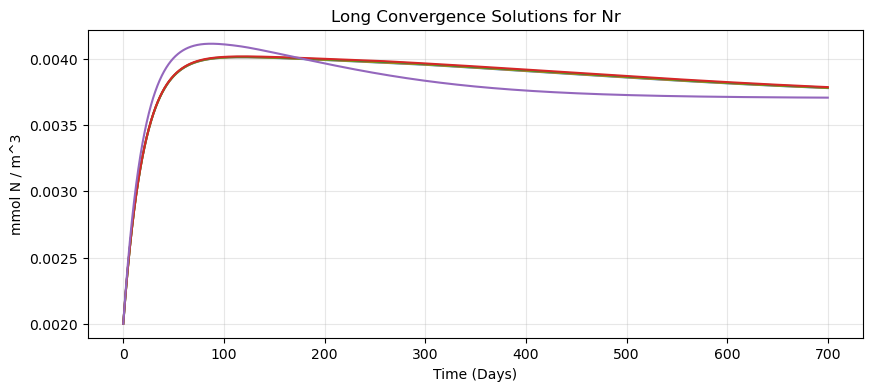

In [25]:
#Plot long term convergent solutions by state variable
plt.figure(figsize=(10, 4))

#Plotting all Nr solutions that converge after 680 days

for k in Nr_df_filtered['Solution #'][50:55]:
    
    print(f'Solution Number: {k}')
    
    sol = ss_sols[k][1]
    plt.plot(sol.t, sol.y[1])

plt.title("Long Convergence Solutions for Nr")
plt.xlabel('Time (Days)')
plt.ylabel('mmol N / m^3')
plt.grid(alpha=.3)
plt.show()

***Invesigation into patterns of convergence...***

In [ ]:
# Convergence histograms illustrating distribution of convergence times 
%matplotlib inline

fig, axs = plt.subplots(2, 3, figsize=(15, 8), constrained_layout = True)

count = 1 # starts at 1 to skip N_n
for row in range(2):
    for col in range(3):
        
        axs[row][col].hist(state_lists[count]['Convergence Time'], color='black', bins=35)
        axs[row][col].set_title(labels[count] + ' Convergence Time')
        axs[row][col].grid(alpha=.3)
        
        #axs[row][col].set_yscale('log')
        axs[row][col].set_xlim(-15, 515)
        axs[row][col].set_xlabel('Time (days)')
        count += 1

In [ ]:
#What are all the solutions hat converge at the end time span?
ss_or_osc(filtered[0][1])


In [ ]:
#What are all the solutions that converge at the end time span?

fig, axs = plt.subplots(2, 3, figsize=(25, 10))
fig.subplots_adjust(bottom=0.3, wspace=0.5)


filtered = [ss_sols[i] for i in filtered_500['Solution #'][3000:3025]]

for i, (z0, solution, ss, conv_time) in enumerate(filtered):

    axs[0][0].plot(solution.t, solution.y[1])
    axs[0][0].scatter(solution.t[conv_time], solution.y[1][conv_time], color='red')
    axs[0][0].set_ylabel(r'N_r mmol N / $m^3$', fontsize=12)
    
    axs[0][1].plot(solution.t, solution.y[2])
    axs[0][1].scatter(solution.t[conv_time], solution.y[2][conv_time], color='red')
    axs[0][1].set_ylabel(r'P_U mmol N / $m^3$', fontsize=12)
    
    axs[0][2].plot(solution.t, solution.y[3])
    axs[0][2].scatter(solution.t[conv_time], solution.y[3][conv_time], color='red')
    axs[0][2].set_ylabel(r'P_I mmol N / $m^3$', fontsize=12)
    
    axs[1][0].plot(solution.t, solution.y[4])
    axs[1][0].scatter(solution.t[conv_time], solution.y[4][conv_time], color='red')
    axs[1][0].set_ylabel(r'Z mmol N / $m^3$', fontsize=12)
    
    axs[1][1].plot(solution.t, solution.y[5], label = f"N_T = {sum(z0):<10.3} z0 = {z0}")
    axs[1][1].scatter(solution.t[conv_time], solution.y[5][conv_time], color='red')
    axs[1][1].set_ylabel(r'V_I mmol N / $m^3$', fontsize=12)
    
    axs[1][2].plot(solution.t, solution.y[6])
    axs[1][2].scatter(solution.t[conv_time], solution.y[6][conv_time], color='red')
    axs[1][2].set_ylabel(r'V_E mmol N / $m^3$', fontsize=12)
    
    
for ax in axs:
    for subax in ax:
        subax.grid(alpha=.3)
        subax.set_xlabel('Time (days)', fontsize=12)
        subax.set_xlim(-10, 510)
        subax.set_yscale('log')
#        subax.set_ylim(1e-4, 1e-3)
        
plt.tight_layout()
#axs[0][1].set_ylim(1e-10, 1e2)
#axs[1][1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3))




In [ ]:
#oscillatory SOLUTIONS WITH periods longer than last ten percent are missed

state = 2
plt.plot(filtered[0][1].t, filtered[0][1].y[state])
plt.plot(filtered[0][1].t[filtered[0][3][state]], filtered[0][1].y[state][filtered[0][3][state]], 'o', color='red')
plt.yscale('log')
plt.grid(alpha=.3)



In [ ]:
ss_or_osc(filtered[0][1])